In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seqm
plt.style.use('dark_background')

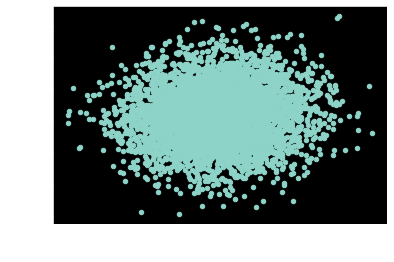

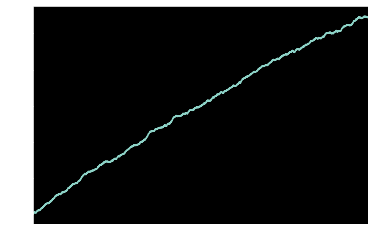

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.56it/s]


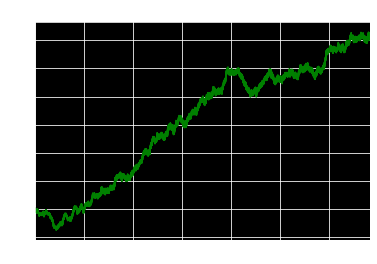

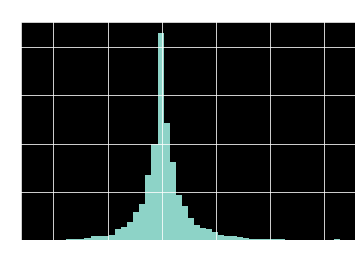

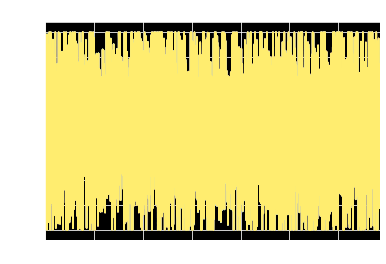

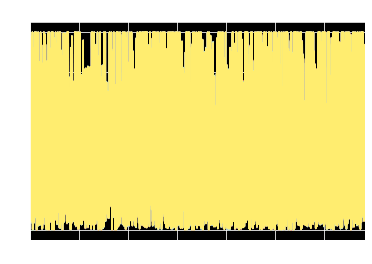


** ACCEPT STRATEGY **


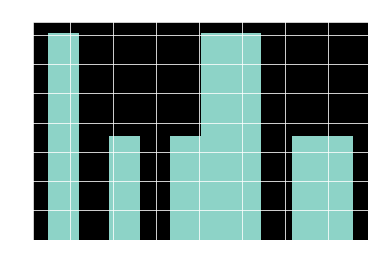

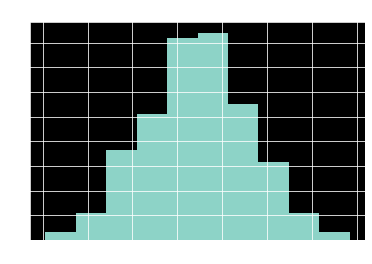


** PERFORMANCE SUMMARY **

Return:  3.028909110324003
Standard deviation:  3.4332179366026927
Sharpe:  0.8822361895619216



,path_1,path_2,path_3,path_4,path_5,path_6,path_7,path_8,path_9,path_10
2000-01-01,0.190832,0.188425,0.189903,0.188425,0.188636,0.189058,0.190283,0.189396,0.191170,0.189945
2000-01-02,0.086113,0.086113,0.086113,0.086113,0.086113,0.086113,0.086113,0.086113,0.086113,0.086113
2000-01-03,-0.141429,-0.141429,-0.141429,-0.141429,-0.141429,-0.141429,-0.141429,-0.141429,-0.141429,-0.141429
2000-01-04,-0.014322,-0.015862,-0.015593,-0.016478,-0.016478,-0.015939,-0.014515,-0.015400,-0.014399,-0.015631
2000-01-05,0.076151,0.075159,0.075761,0.075142,0.075230,0.075425,0.075938,0.075549,0.076292,0.075779
...,...,...,...,...,...,...,...,...,...,...
2013-09-04,-0.378555,-0.380637,-0.381753,-0.381604,-0.378332,-0.380266,-0.377960,-0.379225,-0.378407,-0.381753
2013-09-05,-0.138043,-0.138171,-0.137340,-0.137723,-0.138203,-0.138235,-0.138011,-0.138299,-0.137947,-0.137372
2013-09-06,-0.180425,-0.180795,-0.180101,-0.180448,-0.180541,-0.180795,-0.180309,-0.180749,-0.180309,-0.180124
2013-09-07,-0.008188,-0.008151,-0.008017,-0.008066,-0.008219,-0.008170,-0.008200,-0.008206,-0.008182,-0.008023


In [26]:
n = 5000
# ** PARAMETERS **
# z mean
m = 0.1
# z variance
q = 0.1
# bias
a = 0.1
# correlation feature target
b = 0.1
# noise variance
p = 0.2
# ** SIMULATE PROCESS **
x = np.random.normal(m, np.sqrt(q), n)
eps = np.random.normal(0, np.sqrt(p), n)
y = a + b*x + eps

data = pd.DataFrame(np.hstack([y[:,None],x[:,None]]), columns = ['y','x'], index = pd.date_range('2000-01-01', periods = n, freq = 'D'))

data.plot.scatter('x','y')
plt.show()
np.cumsum(data['y']).plot()
plt.show()

seqm_dataset = seqm.Dataset({'data' : data})

model_pipes = seqm.ModelPipes()

class LR:
    def __init__(self, kelly_std:float = 2, max_w:float = 1, unbiased:bool = False):
        self.kelly_std = kelly_std
        self.max_w = max_w
        self.unbiased = unbiased
        # parameters
        self.a, self.b, self.m, self.p, self.q = None, None, None, None, None
    
    def view(self, **kwargs):
        print('** LR **')
        print('a: ', self.a)
        print('b: ', self.b)
        print('m: ', self.m)
        print('q: ', self.q)
        print('p: ', self.p)
        print('w_norm: ', self.w_norm)
        
    def _linreg(self, X, y):
        '''
        Linear regression from X (matrix) to y (vector)
        '''
        return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
               
    def estimate(self, y, x, **kwargs):
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must be a vector"
        if x.ndim == 2:
            assert x.shape[1] == 1, "x must be a vector"
        y = y[:,0]
        x = x[:,0]
        # add intercept
        X = np.hstack((np.ones((x.size,1)),x[:,None]))
        # make the regression
        c = self._linreg(X, y)
        # compute model parameters
        self.a, self.b = c[0], c[1]
        self.p = np.var(y)
        self.m = np.mean(x)
        self.q = np.var(x)
        self.w_norm = self.kelly_std * np.abs(self.b)*np.sqrt(self.q) / self.p
        # self.view()

    def get_weight(self, xq, **kwargs):
        if isinstance(xq, np.ndarray):
            xq = xq[0]
        if self.unbiased:
            w = self.b * (xq-self.m) / self.p
        else:
            w = (self.a + self.b * xq) / self.p
        w /= self.w_norm
        d = np.abs(w)
        if d > self.max_w:
            w /= d
            w *= self.max_w
        return w

model = LR(kelly_std = 2, max_w = 1, unbiased = True)
model_pipe = seqm.ModelPipe(model = model)
model_pipes['data'] = model_pipe


paths = seqm_dataset.cvbt(
                        model_pipes = model_pipes, # model pipes for the dataset
                        k_folds = 5, # number of cross validation folds
                        seq_path = False,  # preserve time order of data (check blog)
                        start_fold = 0, # used when seq_path = True
                        n_paths = 10, # number of backtest paths to be generated
                        burn_fraction = 0.1, # fraction of training data to be burned to create variability
                        min_burn_points = 3 # min number of points to left out near the testing set 
                        )

seqm.post_process(
                paths = paths, # previously generated paths 
                pct_fee = 0., # percentage fee
                seq_fees = False, # means that the fees are only computed on the weight change
                sr_mult = np.sqrt(250), # in this example, let us assume the data is daily
                n_boot = 1000, # number of bootstrap sample
                )

